# ACCESS Bottom temp

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45639/status,
Dashboard: /proxy/45639/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38899,Workers: 28
Dashboard: /proxy/45639/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:36229,Total threads: 1
Dashboard: /proxy/39335/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44145,


In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/*/ocean/ocean.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds[['sfc_salt_flux_ice','sfc_salt_flux_restore']].sel(yt_ocean=slice(None,-59))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

KeyError: 'sfc_salt_flux_ice'

In [8]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t'].sel(xt_ocean=shelf_mask['xt_ocean'])
areaM = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/output040/ocean/ocean_grid.nc')['area_t'].sel(xt_ocean=shelf_mask['xt_ocean'])

In [10]:
# Temperature variable
tempC = cont['temp']
tempM = melt['temp']

In [11]:
bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'st_ocean': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [12]:
bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'st_ocean': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

#### Mapping

In [16]:
bottemp_cont_map = tempC.where(bottom_mask_tempC).sum(dim='st_ocean').mean(dim='time')
bottemp_pert_map = tempM.where(bottom_mask_tempM).sum(dim='st_ocean').mean(dim='time')
bottemp_anom_ave = bottemp_pert_map - bottemp_cont_map

In [17]:
bottemp_anom_ave = bottemp_anom_ave.load()

In [18]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [19]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

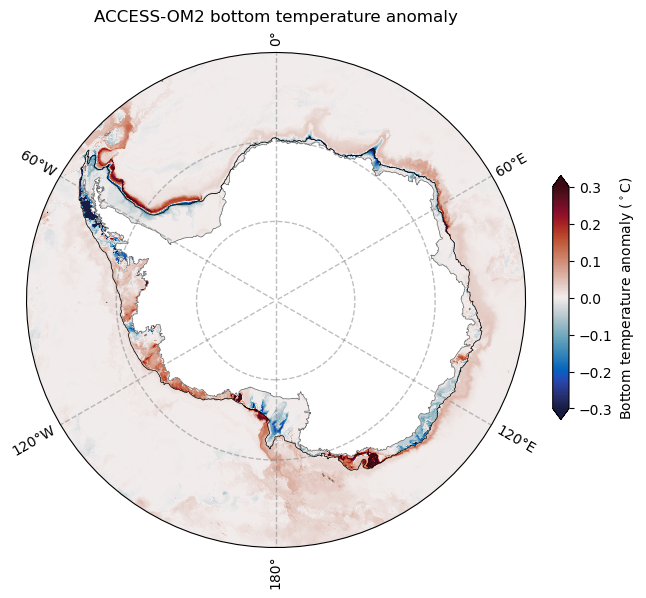

In [21]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
bottemp_anom_ave.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2 bottom temperature anomaly");

### Time series

In [13]:
bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='st_ocean')
bottemp_pert = tempM.where(bottom_mask_tempM).sum(dim='st_ocean')

In [15]:
bottemp_cont = bottemp_cont.mean(dim=['xt_ocean','yt_ocean'])
bottemp_pert = bottemp_pert.mean(dim=['xt_ocean','yt_ocean'])

In [16]:
bottemp_cont = bottemp_cont.load()
bottemp_pert = bottemp_pert.load()

In [17]:
bottemp_anom = bottemp_pert - bottemp_cont
bottemp_anom = bottemp_anom.load()

In [18]:
bottemp_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_bottemp_anom.nc')